# AR Punks
Using an Auto Encoder to generate new punks from old

In [1]:
import sys
sys.path.append('..')
sys.path.append('/home/tnn1t1s/art/cpunks-10k')

import numpy as np
import pandas as pd
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('default')
from matplotlib.colors import rgb2hex
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import cpunks.cpunks10k as cpunks10k
import cpunks.utils as cputils

import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1"    
import tensorflow as tf

In [2]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

In [3]:
cp = cpunks10k.cpunks10k()
(X_train, Y_train), (X_test, Y_test), (labels) = cp.load_data()
X = np.concatenate((X_train, X_test), axis=0)
df = cp.punks_df

### meta parameters

In [4]:
class ContextManager(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


In [5]:
def r_loss(y_true, y_pred):
            return K.mean(K.square(y_true - y_pred), axis = [1,2,3])
ctx = ContextManager({})
ctx.r_loss = r_loss
ctx.learning_rate = 0.0005
ctx.batch_size = 32
ctx.initial_epoch = 0
ctx.input_dim = (24, 24, 4)
ctx.encoder_conv_filters = [32, 64, 64, 64]
ctx.encoder_conv_kernel_size = [3,3,3,3]
ctx.encoder_conv_strides = [1,2,2,1]
ctx.decoder_conv_t_filters = [64,64,32,4]
ctx.decoder_conv_t_kernel_size = [3,3,3,3]
ctx.decoder_conv_t_strides = [1,2,2,1]
ctx.z_dim = 4
ctx.n_layers_encoder = len(ctx.encoder_conv_filters)
ctx.n_layers_decoder = len(ctx.decoder_conv_t_filters)


In [6]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

2022-01-30 18:02:51.692298: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-30 18:02:51.748948: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-30 18:02:51.749211: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [8]:
encoder_input = Input(shape=ctx.input_dim, 
                      name='encoder_input')

x = encoder_input

for i in range(ctx.n_layers_encoder):
    conv_layer = Conv2D(filters = ctx.encoder_conv_filters[i],
                        kernel_size = ctx.encoder_conv_kernel_size[i],
                        strides = ctx.encoder_conv_strides[i],
                        padding = 'same',
                        name = 'encoder_conv_' + str(i))
    x = conv_layer(x)
    x = LeakyReLU()(x)
    
shape_before_flattening = K.int_shape(x)[1:]
x = Flatten()(x)
encoder_output= Dense(ctx.z_dim, name='encoder_output')(x)
encoder = Model(encoder_input, encoder_output)


### The Decoder

In [9]:
decoder_input = Input(shape=(ctx.z_dim,), name='decoder_input')

x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x)

for i in range(ctx.n_layers_decoder):
    conv_t_layer = Conv2DTranspose(filters = ctx.decoder_conv_t_filters[i],
                                   kernel_size = ctx.decoder_conv_t_kernel_size[i],
                                   strides = ctx.decoder_conv_t_strides[i],
                                   padding = 'same',
                                   name = 'decoder_conv_t_' + str(i))
    x = conv_t_layer(x)
    if i < ctx.n_layers_decoder - 1:
        x = LeakyReLU()(x)
        #x = BatchNormalization()(x)
        #x = Dropout(rate = 0.25)(x)
    else:
        x = Activation('sigmoid')(x)

decoder_output = x
decoder = Model(decoder_input, decoder_output)


### Combine to Build the Autoencoder

In [10]:
model_input = encoder_input
model_output = decoder(encoder_output)

model = Model(model_input, model_output)


### Compile

In [11]:
def r_loss(y_true, y_pred):
            return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

In [12]:
optimizer = Adam(learning_rate=ctx.learning_rate)
model.compile(optimizer=optimizer, loss = r_loss)

### Train

In [13]:
from tensorflow.keras.callbacks import Callback, LearningRateScheduler

In [14]:
def step_decay_schedule(initial_lr, decay_factor=0.5, step_size=1):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        new_lr = initial_lr * (decay_factor ** np.floor(epoch/step_size))

        return new_lr

    return LearningRateScheduler(schedule)




In [15]:
epochs = 200

initial_epoch = 0
lr_decay = 1

lr_sched = step_decay_schedule(initial_lr=ctx.learning_rate,
                               decay_factor=lr_decay,
                               step_size=1)

callbacks_list = [lr_sched]

model.fit(X_train,
          X_train,
          batch_size = ctx.batch_size,
          shuffle = True,
          epochs = epochs,
          initial_epoch = initial_epoch,
          callbacks = callbacks_list)

Epoch 1/200


2022-01-30 18:03:26.367203: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8200
2022-01-30 18:03:31.304746: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


282/282 [==============================] - 22s 20ms/step - loss: 0.0527 - lr: 5.0000e-04
Epoch 2/200
282/282 [==============================] - 5s 19ms/step - loss: 0.0212 - lr: 5.0000e-04
Epoch 3/200
282/282 [==============================] - 5s 18ms/step - loss: 0.0175 - lr: 5.0000e-04
Epoch 4/200
282/282 [==============================] - 5s 18ms/step - loss: 0.0159 - lr: 5.0000e-04
Epoch 5/200
282/282 [==============================] - 5s 17ms/step - loss: 0.0146 - lr: 5.0000e-04
Epoch 6/200
282/282 [==============================] - 5s 17ms/step - loss: 0.0138 - lr: 5.0000e-04
Epoch 7/200
282/282 [==============================] - 5s 17ms/step - loss: 0.0132 - lr: 5.0000e-04
Epoch 8/200
282/282 [==============================] - 5s 17ms/step - loss: 0.0127 - lr: 5.0000e-04
Epoch 9/200
282/282 [==============================] - 5s 18ms/step - loss: 0.0123 - lr: 5.0000e-04
Epoch 10/200
282/282 [==============================] - 5s 18ms/step - loss: 0.0120 - lr: 5.0000e-04
Epoch 11/2

282/282 [==============================] - 5s 18ms/step - loss: 0.0062 - lr: 5.0000e-04
Epoch 83/200
282/282 [==============================] - 5s 18ms/step - loss: 0.0062 - lr: 5.0000e-04
Epoch 84/200
282/282 [==============================] - 5s 18ms/step - loss: 0.0062 - lr: 5.0000e-04
Epoch 85/200
282/282 [==============================] - 5s 17ms/step - loss: 0.0061 - lr: 5.0000e-04
Epoch 86/200
282/282 [==============================] - 5s 18ms/step - loss: 0.0061 - lr: 5.0000e-04
Epoch 87/200
282/282 [==============================] - 5s 18ms/step - loss: 0.0062 - lr: 5.0000e-04
Epoch 88/200
282/282 [==============================] - 5s 17ms/step - loss: 0.0061 - lr: 5.0000e-04
Epoch 89/200
282/282 [==============================] - 5s 17ms/step - loss: 0.0061 - lr: 5.0000e-04
Epoch 90/200
282/282 [==============================] - 5s 18ms/step - loss: 0.0060 - lr: 5.0000e-04
Epoch 91/200
282/282 [==============================] - 5s 18ms/step - loss: 0.0060 - lr: 5.0000e-04
Epo

282/282 [==============================] - 5s 18ms/step - loss: 0.0052 - lr: 5.0000e-04
Epoch 163/200
282/282 [==============================] - 5s 18ms/step - loss: 0.0052 - lr: 5.0000e-04
Epoch 164/200
282/282 [==============================] - 5s 18ms/step - loss: 0.0052 - lr: 5.0000e-04
Epoch 165/200
282/282 [==============================] - 5s 18ms/step - loss: 0.0052 - lr: 5.0000e-04
Epoch 166/200
282/282 [==============================] - 5s 18ms/step - loss: 0.0052 - lr: 5.0000e-04
Epoch 167/200
282/282 [==============================] - 5s 17ms/step - loss: 0.0052 - lr: 5.0000e-04
Epoch 168/200
282/282 [==============================] - 5s 17ms/step - loss: 0.0052 - lr: 5.0000e-04
Epoch 169/200
282/282 [==============================] - 5s 17ms/step - loss: 0.0052 - lr: 5.0000e-04
Epoch 170/200
282/282 [==============================] - 5s 17ms/step - loss: 0.0052 - lr: 5.0000e-04
Epoch 171/200
282/282 [==============================] - 5s 17ms/step - loss: 0.0052 - lr: 5.000

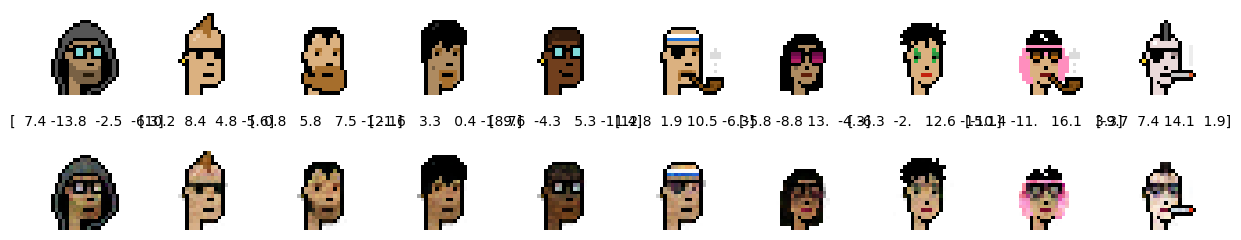

In [16]:
n_to_show = 10
example_idx = np.random.choice(range(len(X_test)), n_to_show)
example_images = X_test[example_idx]

z_points = encoder.predict(example_images)

reconst_images = decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i]#.squeeze()
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)   
    ax.imshow(img)

for i in range(n_to_show):
    img = reconst_images[i]#.squeeze()
    ax = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    ax.axis('off')
    ax.imshow(img)

In [17]:
#reconst_images = AE.decoder.predict(z_points)
z_points

array([[  7.350558  , -13.799404  ,  -2.4654112 ,  -6.299609  ],
       [ 10.241212  ,   8.368749  ,   4.796343  ,  -5.5694203 ],
       [  0.79132587,   5.842957  ,   7.545964  , -12.111668  ],
       [ -1.5601897 ,   3.311593  ,   0.39512634, -18.702225  ],
       [  9.647439  ,  -4.27914   ,   5.257742  , -11.377093  ],
       [ 12.844572  ,   1.8600631 ,  10.4856    ,  -6.2996225 ],
       [ -5.831522  ,  -8.7936535 ,  12.963443  ,  -4.3259063 ],
       [ -6.283666  ,  -2.0380917 ,  12.582578  , -15.064583  ],
       [-10.365253  , -11.024603  ,  16.105639  ,   3.2864196 ],
       [ -9.743848  ,   7.4392285 ,  14.104405  ,   1.9254634 ]],
      dtype=float32)

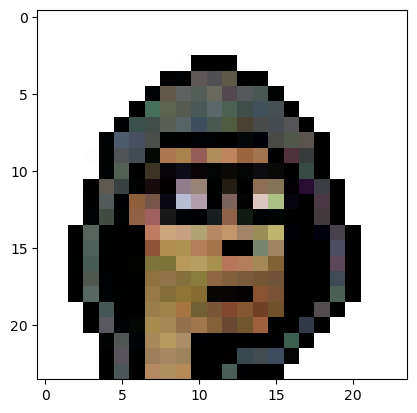

In [24]:
z_s = np.array([[  7.350558  , -13.799404  ,  -2.4654112 ,  -6.299609  ]])
reconst_images = decoder.predict(z_s)
plt.imshow(reconst_images[0])

### pick two punks and do the old face morph trick 

In [155]:
punk_x_img = example_images[0]
punk_y_img = example_images[8]
punk_x_coords = [  7.350558  , -13.799404  ,  -2.4654112 ,  -6.299609  ]
punk_y_coords = [-10.365253  , -11.024603  ,  16.105639  ,   3.2864196 ]

punk_x_coords = [ 10.241212  ,   8.368749  ,   4.796343  ,  -5.5694203 ]
punk_y_coords = [ 12.844572  ,   1.8600631 ,  10.4856    ,  -6.2996225 ]

M=20
x = punk_x_coords
y = punk_y_coords
x = zip(np.linspace(x[0],y[0],M),
        np.linspace(x[1],y[1],M),
        np.linspace(x[2],y[2],M),
        np.linspace(x[3],y[3],M),
       )
z_s = np.array(list(x))
#z_s = np.array([[  7.350558  , -13.799404  ,  -2.4654112 ,  -6.299609  ]])
reconst_images = decoder.predict(z_s)
#plt.imshow(reconst_images[8])

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(M):
    img = reconst_images[i]#.squeeze()
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    ax.imshow(img)

In [156]:
imgs_reversed = np.array([reconst_images[i] for i in range(len(reconst_images) - 1, -1, -1)])
imgs = np.concatenate((reconst_images, imgs_reversed))

In [157]:
import matplotlib.animation as animation
%matplotlib qt

imagelist=imgs 
fig = plt.figure() # make figure

# make axesimage object
# the vmin and vmax here are very important to get the color map correct
im = plt.imshow(imagelist[0]) #, cmap=plt.get_cmap('jet'), vmin=0, vmax=255)

# function to update figure
def updatefig(j):
    # set the data in the axesimage object
    im.set_array(imagelist[j])
    # return the artists set
    return [im]
# kick off the animation
ani = animation.FuncAnimation(fig, updatefig, frames=range(40), 
                             interval=48)
plt.show()

In [75]:
np.fliplr(imagelist)

array([[[[8.64586527e-12, 7.10837611e-10, 1.68376829e-07,
          4.89376898e-12],
         [4.03700892e-11, 2.29041408e-09, 4.25779461e-07,
          1.89102030e-13],
         [5.75029954e-12, 9.33254099e-11, 2.21646470e-08,
          3.06190147e-18],
         ...,
         [8.57713511e-10, 1.11316574e-08, 7.32500894e-07,
          1.17457122e-09],
         [1.10890455e-11, 6.31631483e-11, 4.33741789e-08,
          5.85374570e-16],
         [1.03824671e-10, 1.99174538e-10, 8.81360762e-10,
          2.08911459e-22]],

        [[4.78918016e-10, 8.89664165e-09, 2.47082824e-07,
          1.84946936e-11],
         [1.26472192e-14, 4.90675805e-13, 3.78869575e-11,
          6.62591988e-19],
         [1.41955675e-13, 4.07707505e-12, 1.90998762e-11,
          8.33951516e-17],
         ...,
         [1.83769579e-12, 1.01226026e-12, 1.23071178e-10,
          3.33326357e-13],
         [3.92778574e-16, 2.78426109e-16, 9.44868641e-16,
          1.64005501e-19],
         [2.02744822e-18, 1.2589871

In [ ]:
fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

In [29]:
def bounded_random_walk(length, lower_bound,  upper_bound, start, end, std):
    assert (lower_bound <= start and lower_bound <= end)
    assert (start <= upper_bound and end <= upper_bound)

    bounds = upper_bound - lower_bound

    rand = (std * (np.random.random(length) - 0.5)).cumsum()
    rand_trend = np.linspace(rand[0], rand[-1], length)
    rand_deltas = (rand - rand_trend)
    rand_deltas /= np.max([1, (rand_deltas.max()-rand_deltas.min())/bounds])

    trend_line = np.linspace(start, end, length)
    upper_bound_delta = upper_bound - trend_line
    lower_bound_delta = lower_bound - trend_line

    upper_slips_mask = (rand_deltas-upper_bound_delta) >= 0
    upper_deltas =  rand_deltas - upper_bound_delta
    rand_deltas[upper_slips_mask] = (upper_bound_delta - upper_deltas)[upper_slips_mask]

    lower_slips_mask = (lower_bound_delta-rand_deltas) >= 0
    lower_deltas =  lower_bound_delta - rand_deltas
    rand_deltas[lower_slips_mask] = (lower_bound_delta + lower_deltas)[lower_slips_mask]

    return trend_line + rand_deltas

randomData = bounded_random_walk(1000, lower_bound=50, upper_bound =100, start=50, end=100, std=10)
randomData

array([ 50.        ,  50.22951001,  51.65954843,  53.54784071,
        54.16080199,  52.62690164,  51.33685056,  51.96529875,
        53.81171398,  53.46036084,  51.97383462,  50.42967686,
        51.2597444 ,  50.35699308,  50.99130769,  50.73309503,
        50.37042526,  50.51658112,  50.68231661,  50.81549758,
        50.15148978,  51.0301716 ,  50.13155094,  50.15137389,
        51.58692929,  52.48626729,  50.64413343,  50.07071077,
        50.23037206,  51.31181615,  52.18496392,  52.89935137,
        52.61700356,  52.00899919,  50.21616944,  51.74719467,
        52.50753001,  50.67923493,  52.290616  ,  51.09142722,
        53.04009299,  53.49699457,  51.60103674,  52.40731132,
        54.12604298,  55.66700451,  54.55200258,  56.46347237,
        57.75534135,  57.1542537 ,  58.31410262,  59.38042541,
        60.16157668,  61.74301148,  62.79063647,  62.27384778,
        62.30159501,  61.00634676,  62.1390522 ,  63.37709705,
        63.8369324 ,  65.27531457,  66.064945  ,  66.38

## Reducing Dimensions and staying true to the colorpunx

In [32]:
(mnist_x_train, mnist_y_train), (mnist_x_test, minst_y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [37]:
type(mnist_x_train[0][0][0])

numpy.uint8

In [68]:
type(X_train[0][0][0][0])

numpy.float32

Training the AR on the (24,24,4) sized input gave some interesting results, specifically, we saw that the pixel colors mutated into a blend of the mostlikely colors. but, these are n'/t actualy cryptopunks. we can greatly simmply the model by limting the colors tot he 2222 colrso used in CPACV-10

map every X_train[0] to (24,24, 1) where the color channel is uint8 and maps to a colormap that can be used to reconstruct later.

In [143]:
import pickle

class CryptoPunksColorMap:
    def __init__(self):
        with open(f"../data/_colors_count.pickle", 'rb') as f:
            self.colors_count = pickle.load(f)
            self.colors = list(self.colors_count.keys())
            self.color_d = {}
            i=0
            for k in self.colors:
                self.color_d[k] = i
                i+=1
    
    def flatten(self, img):
        return np.array([[self.colors_d[str(c)] for c in row]
                                    for row in img]).astype(np.uint8)
    
    def unflatten(self,img):
        return np.array([[np.fromstring(self.colors[c][1:-1], float, sep=' ') for c in row]
                                                                       for row in img])

cpm = CryptoPunksColorMap()

### Prepare a new Training Set with lower dimensionality

In [5]:
#X_train_flat = [cpm.flatten(img) for img in X_train]
#X_test_flat  = [cpm.flatten(img) for img in X_test]

In [40]:
# pickle them so we can restore progress
with open(f"../data/_x_train_flat.pickle", 'wb') as filehandler:
    pickle.dump(X_train_flat, filehandler)
with open(f"../data/_x_test_flat.pickle", 'wb') as filehandler:
    pickle.dump(X_test_flat, filehandler)

### test the pickle files

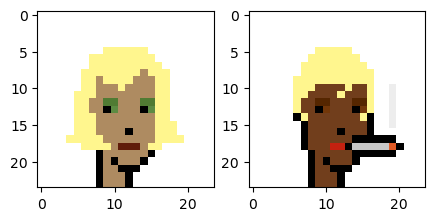

In [47]:
X_train_flat = None
X_test_flat = None

with open(f"../data/_x_train_flat.pickle", 'rb') as f:
    X_train_flat = np.array(pickle.load(f))

with open(f"../data/_x_test_flat.pickle", 'rb') as f:
    X_test_flat = np.array(pickle.load(f))


fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1,2,1) 
ax.imshow(cpm.unflatten(X_train_flat[0]))
ax = fig.add_subplot(1,2,2)  
ax.imshow(cpm.unflatten(X_test_flat[0]))

### Train a model

In [48]:
ctx.input_dim = (24, 24, 1)
ctx.encoder_conv_filters = [32, 64, 64, 64]
ctx.encoder_conv_kernel_size = [3,3,3,3]
ctx.encoder_conv_strides = [1,2,2,1]
ctx.decoder_conv_t_filters = [64,64,32,1]
ctx.decoder_conv_t_kernel_size = [3,3,3,3]
ctx.decoder_conv_t_strides = [1,2,2,1]
ctx.z_dim = 3
ctx.n_layers_encoder = len(ctx.encoder_conv_filters)
ctx.n_layers_decoder = len(ctx.decoder_conv_t_filters)

In [62]:
X_train_flat[0].shape

(24, 24)

In [49]:
encoder_input = Input(shape=ctx.input_dim, 
                      name='encoder_input')

x = encoder_input

for i in range(ctx.n_layers_encoder):
    conv_layer = Conv2D(filters = ctx.encoder_conv_filters[i],
                        kernel_size = ctx.encoder_conv_kernel_size[i],
                        strides = ctx.encoder_conv_strides[i],
                        padding = 'same',
                        name = 'encoder_conv_' + str(i))
    x = conv_layer(x)
    x = LeakyReLU()(x)
    #x = BatchNormalization()(x)
    #x = Dropout(rate = 0.25)(x)
    
shape_before_flattening = K.int_shape(x)[1:]
x = Flatten()(x)
encoder_output= Dense(ctx.z_dim, name='encoder_output')(x)
encoder = Model(encoder_input, encoder_output)


In [59]:
encoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 24, 24, 1)]       0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 24, 24, 32)        320       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 24, 24, 32)        0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 12, 12, 64)        18496     
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 12, 12, 64)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 6, 6, 64)          36928     
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 6, 6, 64)          0   

In [50]:
decoder_input = Input(shape=(ctx.z_dim,), name='decoder_input')

x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x)

for i in range(ctx.n_layers_decoder):
    conv_t_layer = Conv2DTranspose(filters = ctx.decoder_conv_t_filters[i],
                                   kernel_size = ctx.decoder_conv_t_kernel_size[i],
                                   strides = ctx.decoder_conv_t_strides[i],
                                   padding = 'same',
                                   name = 'decoder_conv_t_' + str(i))
    x = conv_t_layer(x)
    if i < ctx.n_layers_decoder - 1:
        x = LeakyReLU()(x)
        #x = BatchNormalization()(x)
        #x = Dropout(rate = 0.25)(x)
    else:
        x = Activation('sigmoid')(x)

decoder_output = x
decoder = Model(decoder_input, decoder_output)

In [51]:
model_input = encoder_input
model_output = decoder(encoder_output)

model = Model(model_input, model_output)


In [52]:
optimizer = Adam(lr=ctx.learning_rate)
model.compile(optimizer=optimizer, loss = r_loss)

In [194]:
X_train_flat_float = X_train_flat.astype('float32') / 255.
X_test_flat_float = X_test_flat.astype('float32') / 255.

In [56]:
epochs = 5

initial_epoch = 0
lr_decay = 1

lr_sched = step_decay_schedule(initial_lr=ctx.learning_rate,
                               decay_factor=ctx.lr_decay,
                               step_size=1)

callbacks_list = [lr_sched]

model.fit(X_train_flat_float,
          X_train_flat_float,
          batch_size = ctx.batch_size,
          shuffle = True,
          epochs = epochs,
          initial_epoch = initial_epoch)

Epoch 1/5


ValueError: in user code:

    /home/tnn1t1s/miniconda3/envs/colorpunx/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /tmp/ipykernel_679218/3423225362.py:2 r_loss  *
        return K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    /home/tnn1t1s/miniconda3/envs/colorpunx/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:201 wrapper  **
        return target(*args, **kwargs)
    /home/tnn1t1s/miniconda3/envs/colorpunx/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:2342 mean
        return math_ops.reduce_mean(x, axis, keepdims)
    /home/tnn1t1s/miniconda3/envs/colorpunx/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/tnn1t1s/miniconda3/envs/colorpunx/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:2370 reduce_mean
        gen_math_ops.mean(
    /home/tnn1t1s/miniconda3/envs/colorpunx/lib/python3.9/site-packages/tensorflow/python/ops/gen_math_ops.py:5780 mean
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /home/tnn1t1s/miniconda3/envs/colorpunx/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /home/tnn1t1s/miniconda3/envs/colorpunx/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py:590 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /home/tnn1t1s/miniconda3/envs/colorpunx/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:3528 _create_op_internal
        ret = Operation(
    /home/tnn1t1s/miniconda3/envs/colorpunx/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:2015 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /home/tnn1t1s/miniconda3/envs/colorpunx/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:1856 _create_c_op
        raise ValueError(str(e))

    ValueError: Invalid reduction dimension 3 for input with 3 dimensions. for '{{node r_loss/Mean}} = Mean[T=DT_FLOAT, Tidx=DT_INT32, keep_dims=false](r_loss/Square, r_loss/Mean/reduction_indices)' with input shapes: [?,24,24], [3] and with computed input tensors: input[1] = <1 2 3>.


In [58]:
from keras import layers

In [241]:

# This is the size of our encoded representations
encoding_dim = 8  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
L = 576
# This is our input image
input_img = Input(shape=(L,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(L, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [242]:
# This model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [243]:
# This is our encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [244]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [245]:
x_train = X_train_flat_float.reshape((len(X_train_flat_float), np.prod(X_train_flat_float.shape[1:])))
x_test = X_test_flat_float.reshape((len(X_test_flat_float), np.prod(X_test_flat_float.shape[1:])))
(x_train.shape, x_test.shape)

((9000, 576), (1000, 576))

In [247]:
autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/200
36/36 [==============================] - 0s 14ms/step - loss: 0.2033 - val_loss: 0.1978
Epoch 2/200
36/36 [==============================] - 0s 11ms/step - loss: 0.1911 - val_loss: 0.1883
Epoch 3/200
36/36 [==============================] - 0s 10ms/step - loss: 0.1822 - val_loss: 0.1810
Epoch 4/200
36/36 [==============================] - 1s 20ms/step - loss: 0.1752 - val_loss: 0.1751
Epoch 5/200
36/36 [==============================] - 0s 13ms/step - loss: 0.1694 - val_loss: 0.1699
Epoch 6/200
36/36 [==============================] - 1s 14ms/step - loss: 0.1646 - val_loss: 0.1656
Epoch 7/200
36/36 [==============================] - 0s 12ms/step - loss: 0.1603 - val_loss: 0.1617
Epoch 8/200
36/36 [==============================] - 0s 13ms/step - loss: 0.1566 - val_loss: 0.1581
Epoch 9/200
36/36 [==============================] - 0s 11ms/step - loss: 0.1531 - val_loss: 0.1548
Epoch 10/200
36/36 [==============================] - 0s 10ms/step - loss: 0.1499 - val_loss: 0.1517

36/36 [==============================] - 1s 14ms/step - loss: 0.0815 - val_loss: 0.0860
Epoch 163/200
36/36 [==============================] - 0s 12ms/step - loss: 0.0814 - val_loss: 0.0860
Epoch 164/200
36/36 [==============================] - 1s 15ms/step - loss: 0.0814 - val_loss: 0.0860
Epoch 165/200
36/36 [==============================] - 0s 13ms/step - loss: 0.0814 - val_loss: 0.0859
Epoch 166/200
36/36 [==============================] - 0s 12ms/step - loss: 0.0814 - val_loss: 0.0859
Epoch 167/200
36/36 [==============================] - 1s 15ms/step - loss: 0.0814 - val_loss: 0.0859
Epoch 168/200
36/36 [==============================] - 0s 11ms/step - loss: 0.0814 - val_loss: 0.0859
Epoch 169/200
36/36 [==============================] - 0s 11ms/step - loss: 0.0813 - val_loss: 0.0859
Epoch 170/200
36/36 [==============================] - 0s 11ms/step - loss: 0.0813 - val_loss: 0.0859
Epoch 171/200
36/36 [==============================] - 0s 12ms/step - loss: 0.0813 - val_loss: 0

In [248]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [250]:
(decoded_imgs[0].reshape(24,24)* 255)[12] * 255


array([1.4041994e+01, 2.1154074e+01, 1.7249212e+01, 4.8714056e+00,
       5.6191235e+01, 1.4070480e+02, 1.9262086e+03, 2.0370775e+03,
       1.0633215e+03, 1.2425227e+03, 2.0326396e+03, 9.8935016e+02,
       1.9111764e+03, 9.6963013e+02, 1.2591266e+03, 2.2318088e+03,
       8.3491150e+02, 1.8765034e+02, 2.4247536e+02, 1.6163735e+04,
       8.0074640e+02, 5.7646594e+02, 1.5890747e+01, 1.6485682e+01],
      dtype=float32)

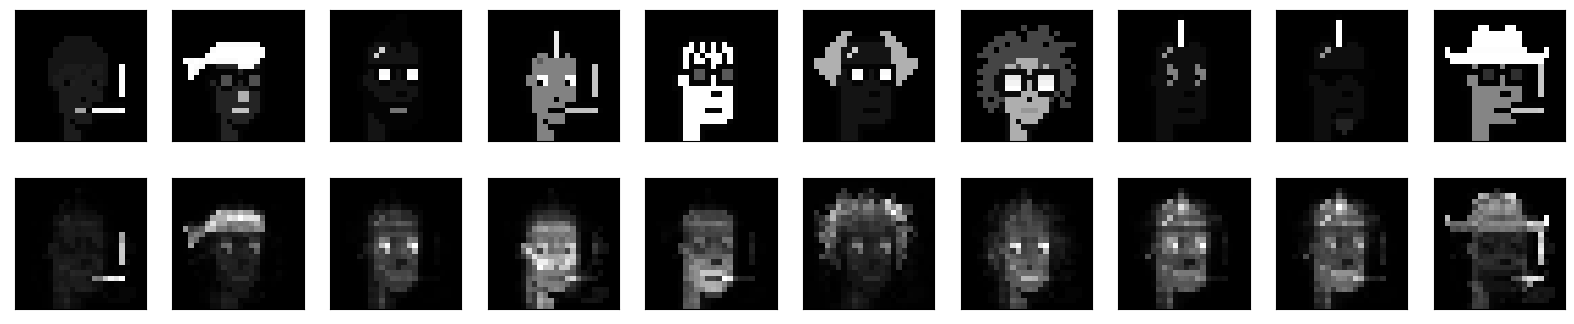

In [251]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(24, 24))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(24, 24))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()